<a href="https://colab.research.google.com/github/amostof/deepxde/blob/master/0DE/0DE_PE_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages (run only once in the runtime)

In [1]:
!pip install deepxde

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 860kB 8.2MB/s 
  Created wheel for salib: filename=SALib-1.3.12-py2.py3-none-any.whl size=729049 sha256=c56c218fb25078162b3170eb9671726427f81c6bd17077e6e7734fefd14ffa48
  Stored in directory: /root/.cache/pip/wheels/04/5c/9f/09d58ab84d5a7ef7d2e5fedc5cd2f46a64a77c99035571aa0c
Successfully built salib


Imports and functions

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


# get training data
def gen_traindata():
    response = requests.get('https://github.com/lululxvi/deepxde/raw/master/examples/dataset/Lorenz.npz')
    response.raise_for_status()
    data = np.load(io.BytesIO(response.content))
    return data["t"], data["y"]

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8/3

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


Define data and BCs

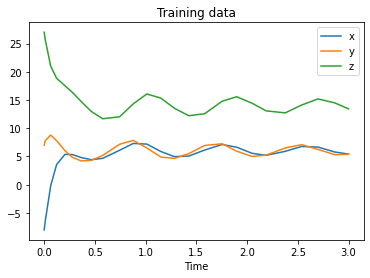

In [3]:
# define time domain
geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the training data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

plt.plot(observe_t, ob_y)
plt.xlabel('Time')
plt.legend(['x','y','z'])
plt.title('Training data')
plt.show()


Train network

In [4]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.074082 s



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.955325 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.05e-01, 1.85e-01, 4.07e-03, 6.40e+01, 4.90e+01, 7.29e+02, 3.47e+01, 4.28e+01, 2.58e+02]    [1.05e-01, 1.85e-01, 4.07e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.77e+00, 3.11e+00, 3.15e+00, 3.23e+01, 8.30e-04, 1.85e+00, 3.31e+01, 7.08e+00, 1.04e+01]    [5.77e+00, 3.11e+00, 3.15e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [9.19e+00, 2.02e+00, 1.34e+00, 1.78e+01, 3.13e-01, 1.61e+00, 3.29e+01, 1.42e+01, 4.91e+00]    [9.19e+00, 2.02e+00, 1.34e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [8.76e+00, 1.94e+00, 9.18e-01, 1.37e+01, 3.88e-01, 1.48e+00, 3.29e+01, 1.81e+01, 2.98e+00]    [8.76

 Plot identified parameters

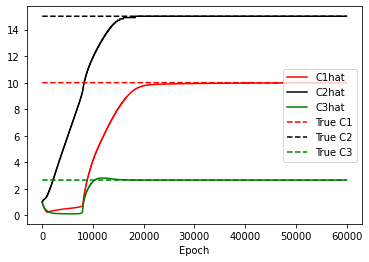

In [5]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

Predicting...
'predict' took 0.018263 s



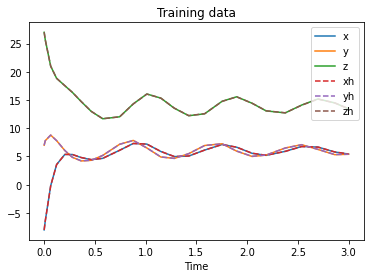

In [6]:
yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()